# Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import eli5

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

from eli5.sklearn import PermutationImportance

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

np.random.seed(1067)

import os
import joblib

dest = os.path.join(os.getcwd(), 'clf_joblib_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

/home/hmnguyen1067/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/hmnguyen1067/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/hmnguyen1067/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
plt.rcParams["figure.figsize"] = (14,8)

# Data preprocessing

In [3]:
fullData = pd.read_csv("coding_round_data.csv")

In [4]:
# Categorial columns
cat = ["Administrative", "Informational", 
       "ProductRelated", "SpecialDay", "Month", 
       "OperatingSystems", "Browser", "Region", 
       "TrafficType", "VisitorType", "Weekend"]

# Numerical Columns
num = ["Administrative_Duration", "Informational_Duration", 
       "ProductRelated_Duration", "BounceRates", "ExitRates",
       "PageValues"]

# Cast boolean values to integer
fullData.Weekend = fullData.Weekend.astype(int)
fullData.Revenue = fullData.Revenue.astype(int)
fullData.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,1,0


In [5]:
# Check if there is any null values
fullData.isnull().values.any()

False

In [6]:
# Full data numerical variables description
fullData[num].describe()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,80.818611,34.472398,1194.746220,0.022191,0.043073,5.889258
std,176.779107,140.749294,1913.669288,0.048488,0.048597,18.568437
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,184.137500,0.000000,0.014286,0.000000
50%,7.500000,0.000000,598.936905,0.003112,0.025156,0.000000
75%,93.256250,0.000000,1464.157214,0.016813,0.050000,0.000000
max,3398.750000,2549.375000,63973.522230,0.200000,0.200000,361.763742


In [7]:
# The percentage of which Revenue is true given by Administrative attribute with count and sorted
(
    fullData
    .groupby("Administrative")
    .agg({'Revenue': ['mean', 'count']})
    .sort_values([('Revenue', 'mean')], ascending = False)
)

Revenue      
                    mean count
Administrative                
26              1.000000     1
22              0.500000     4
20              0.500000     2
13              0.339286    56
16              0.333333    24
11              0.295238   105
14              0.272727    44
9               0.271111   225
6               0.256944   432
8               0.254355   287
17              0.250000    16
12              0.244186    86
1               0.214919  1354
15              0.210526    38
10              0.209150   153
5               0.205217   575
4               0.200000   765
7               0.195266   338
3               0.190164   915
2               0.184022  1114
18              0.166667    12
19              0.166667     6
0               0.089112  5768
23              0.000000     3
24              0.000000     4
21              0.000000     2
27              0.000000     1

In [8]:
# The percentage of which Revenue is true given by Informational attribute with count and sorted
(
    fullData
    .groupby("Informational")
    .agg({'Revenue': ['mean', 'count']})
    .sort_values([('Revenue', 'mean')], ascending = False)
)

Revenue      
                   mean count
Informational                
12             0.400000     5
9              0.400000    15
5              0.313131    99
8              0.285714    14
10             0.285714     7
4              0.279279   222
3              0.244737   380
1              0.226705  1041
6              0.217949    78
2              0.211538   728
7              0.166667    36
0              0.133519  9699
11             0.000000     1
13             0.000000     1
14             0.000000     2
16             0.000000     1
24             0.000000     1

In [9]:
# The percentage of which Revenue is true given by Month attribute with count and sorted
(
    fullData
    .groupby("Month")
    .agg({'Revenue': ['mean', 'count']})
    .sort_values([('Revenue', 'mean')], ascending = False)
)

Revenue      
           mean count
Month                
Nov    0.253502  2998
Oct    0.209472   549
Sep    0.191964   448
Aug    0.175520   433
Jul    0.152778   432
Dec    0.125072  1727
May    0.108502  3364
June   0.100694   288
Mar    0.100682  1907
Feb    0.016304   184

We can see that the percentages in the later half of the year is better than the early half.

In [10]:
# The percentage of which Revenue is true given by Region attribute with count and sorted
(
    fullData
    .groupby("Region")
    .agg({'Revenue': ['mean', 'count']})
    .sort_values([('Revenue', 'mean')], ascending = False)
)


Revenue      
            mean count
Region                
9       0.168297   511
2       0.165493  1136
5       0.163522   318
1       0.161297  4780
7       0.156373   761
4       0.148054  1182
3       0.145235  2403
6       0.139130   805
8       0.129032   434

The differences in percentage between regions aren't significant.

In [11]:
# The percentage of which Revenue is true given by TrafficType attribute with count and sorted
(
    fullData
    .groupby("TrafficType")
    .agg({'Revenue': ['mean', 'count']})
    .sort_values([('Revenue', 'mean')], ascending = False)
)


Revenue      
                 mean count
TrafficType                
16           0.333333     3
7            0.300000    40
8            0.276968   343
20           0.252525   198
2            0.216458  3913
5            0.215385   260
10           0.200000   450
11           0.190283   247
4            0.154350  1069
14           0.153846    13
6            0.119369   444
1            0.106895  2451
9            0.095238    42
3            0.087719  2052
19           0.058824    17
13           0.058266   738
12           0.000000     1
15           0.000000    38
17           0.000000     1
18           0.000000    10

In [12]:
# The percentage of which Revenue is true given by Weekend attribute
(
    fullData
    .groupby("Weekend")
    .agg({'Revenue': ['mean', 'count']})
)

Revenue      
             mean count
Weekend                
0        0.148911  9462
1        0.173989  2868

The results give back that there aren't much of a difference in percentage between weekday and weekend.

In [13]:
# The percentage of which Revenue is true given by SpecialDay attribute
(
    fullData
    .groupby("SpecialDay")
    .agg({'Revenue': ['mean', 'count']})
)

Revenue       
                mean  count
SpecialDay                 
0.0         0.165268  11079
0.2         0.078652    178
0.4         0.053498    243
0.6         0.082621    351
0.8         0.033846    325
1.0         0.064935    154

The result above shows that getting near to a special day isn't any better at buying a product than normal days.

In [14]:
# The percentage of which Revenue is true given by VisitorType attribute
(
    fullData
    .groupby("VisitorType")
    .agg({'Revenue': ['mean', 'count']})
)

Revenue       
                       mean  count
VisitorType                       
New_Visitor        0.249115   1694
Other              0.188235     85
Returning_Visitor  0.139323  10551

Even though there are a lot of data points by returning visitors but new visitor has the better chance of buying a product.

In [15]:
# Statistics description of numerical variables
def q80(x):
    return x.quantile(0.8)

fullData.groupby('Revenue')[num].agg(['mean', 'std', 
                                      'min', 'median',
                                      q80, 'max']).T

Revenue                                    0             1
Administrative_Duration mean       73.740111    119.483244
                        std       171.017970    201.114732
                        min         0.000000      0.000000
                        median      0.000000     52.366667
                        q80       109.780000    184.549091
                        max      3398.750000   2086.750000
Informational_Duration  mean       30.236237     57.611427
                        std       133.909306    171.619131
                        min         0.000000      0.000000
                        median      0.000000      0.000000
                        q80         0.000000     42.960000
                        max      2549.375000   1767.666667
ProductRelated_Duration mean     1069.987809   1876.209615
                        std      1803.797757   2312.214392
                        min         0.000000      0.000000
                        median    510.190000   1109.906250
                        q80      1621.643750   2699.246264
                        max     63973.522230  27009.859430
BounceRates             mean        0.025317      0.005117
                        std         0.051877      0.012185
                        min         0.000000      0.000000
                        median      0.004255      0.000000
                        q80         0.028571      0.008082
                        max         0.200000      0.200000
ExitRates               mean        0.047378      0.019555
                        std         0.051231      0.016463
                        min         0.000000      0.000000
                        median      0.028571      0.016000
                        q80         0.066667      0.028076
                        max         0.200000      0.200000
PageValues              mean        1.975998     27.264518
                        std         9.072424     35.191954
                        min         0.000000      0.000000
                        median      0.000000     16.758134
                        q80         0.000000     45.680259
                        max       246.758590    361.763742

# Exploratory data visualizations

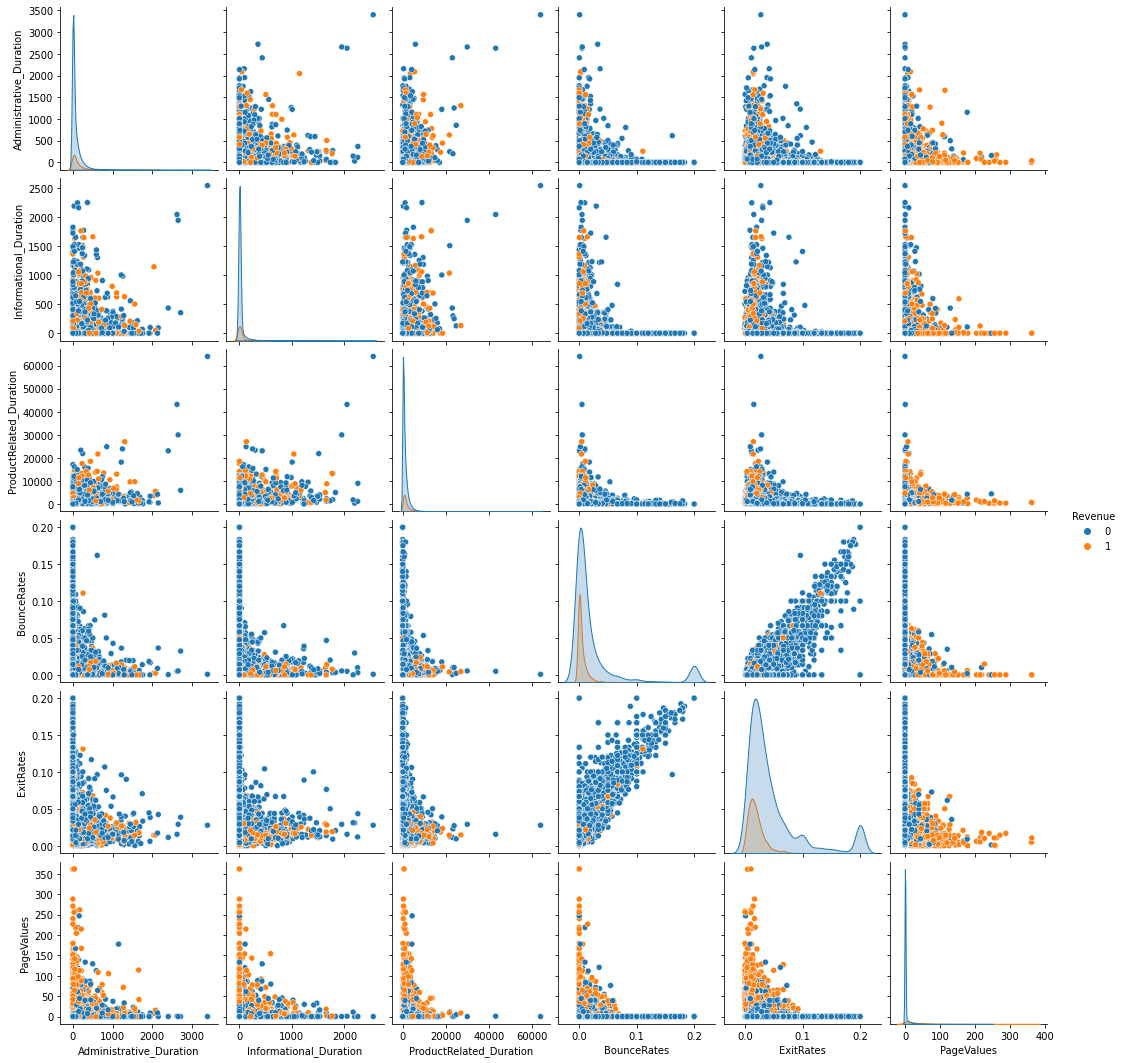

In [16]:
sns.pairplot(fullData, vars=num, hue='Revenue')

Text(0.5, 1.0, 'Numerical features correlations')

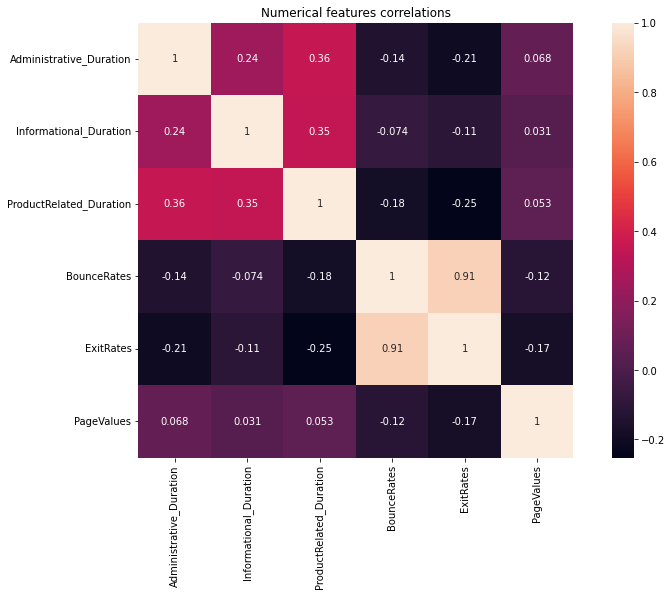

In [17]:
sns.heatmap(fullData[num].corr(), vmax = 1, annot=True, square=True)
plt.title('Numerical features correlations')

<AxesSubplot:xlabel='Administrative', ylabel='Administrative_Duration'>

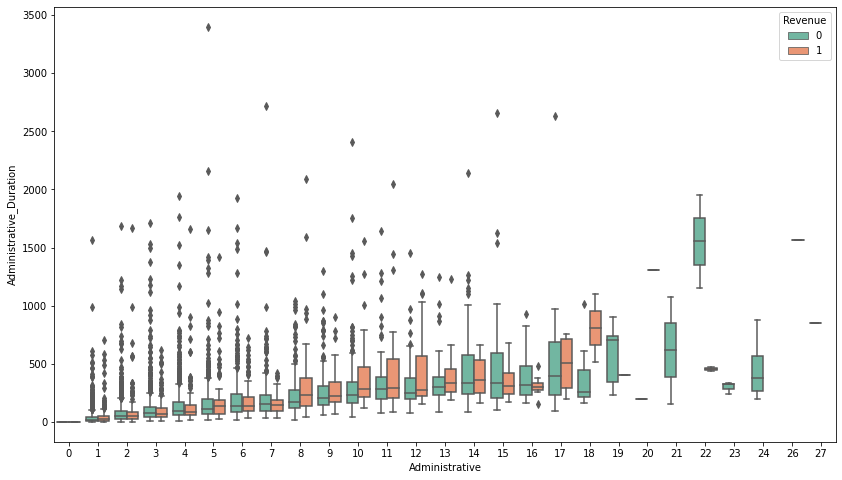

In [18]:
sns.boxplot(data=fullData, x='Administrative', y='Administrative_Duration', 
            hue='Revenue', palette='Set2')

<AxesSubplot:xlabel='Informational', ylabel='Informational_Duration'>

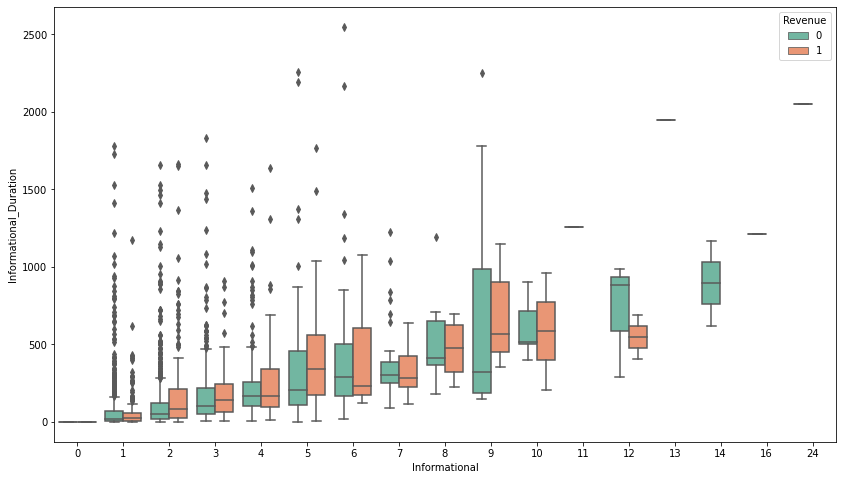

In [19]:
sns.boxplot(data=fullData, x='Informational', y='Informational_Duration', 
            hue='Revenue', palette='Set2')

<AxesSubplot:xlabel='Administrative', ylabel='PageValues'>

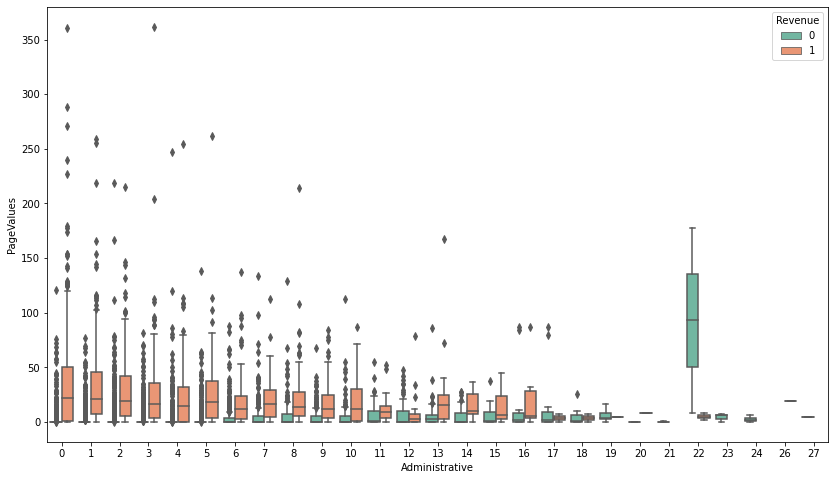

In [20]:
sns.boxplot(data=fullData, x='Administrative', y='PageValues', 
            hue='Revenue', palette='Set2')

<AxesSubplot:xlabel='Administrative', ylabel='ProductRelated_Duration'>

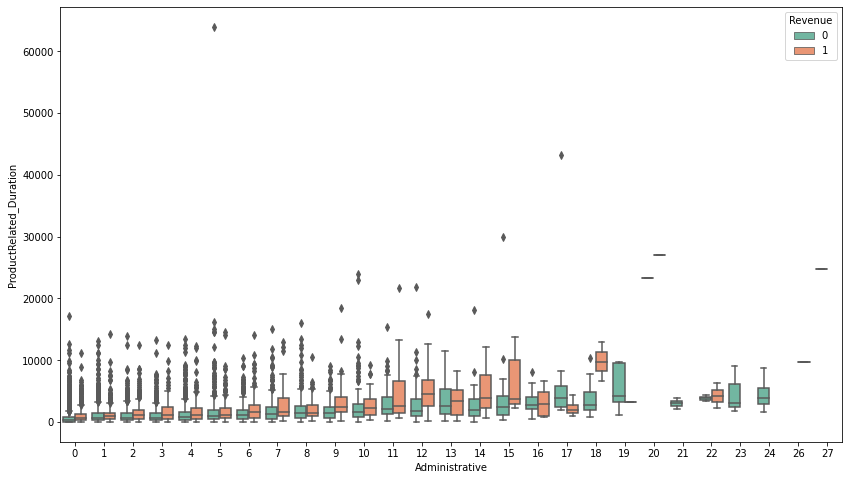

In [21]:
sns.boxplot(data=fullData, x='Administrative', y='ProductRelated_Duration', 
            hue='Revenue', palette='Set2')

<AxesSubplot:xlabel='Administrative', ylabel='BounceRates'>

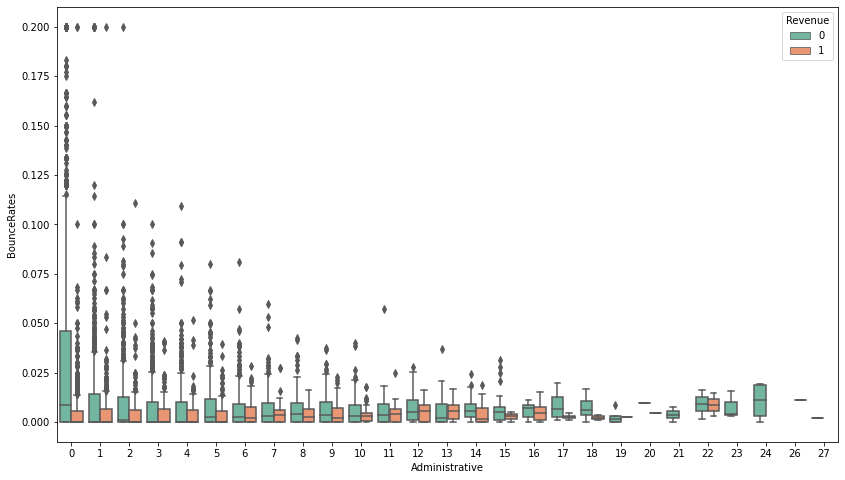

In [22]:
sns.boxplot(data=fullData, x='Administrative', y='BounceRates', 
            hue='Revenue', palette='Set2')

<AxesSubplot:xlabel='Administrative', ylabel='ExitRates'>

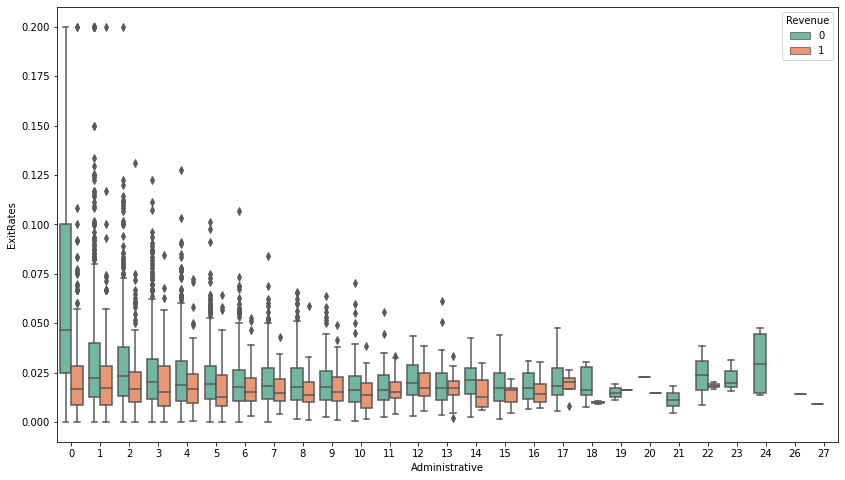

In [23]:
sns.boxplot(data=fullData, x='Administrative', y='ExitRates', 
            hue='Revenue', palette='Set2')

# Feature importance

In [24]:
# Seperate labeling for feature importance
labels = fullData.Revenue
data = fullData.drop(columns=['Revenue'])

In [25]:
# One-hot encoding categorical features
feaImpData = pd.get_dummies(data, columns= cat)
cols = feaImpData.columns
y_ticks = np.arange(0, 15)

## Impurity-based feature importance

/tmp/ipykernel_1439/2189211491.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(cols[RFsortedIdx])


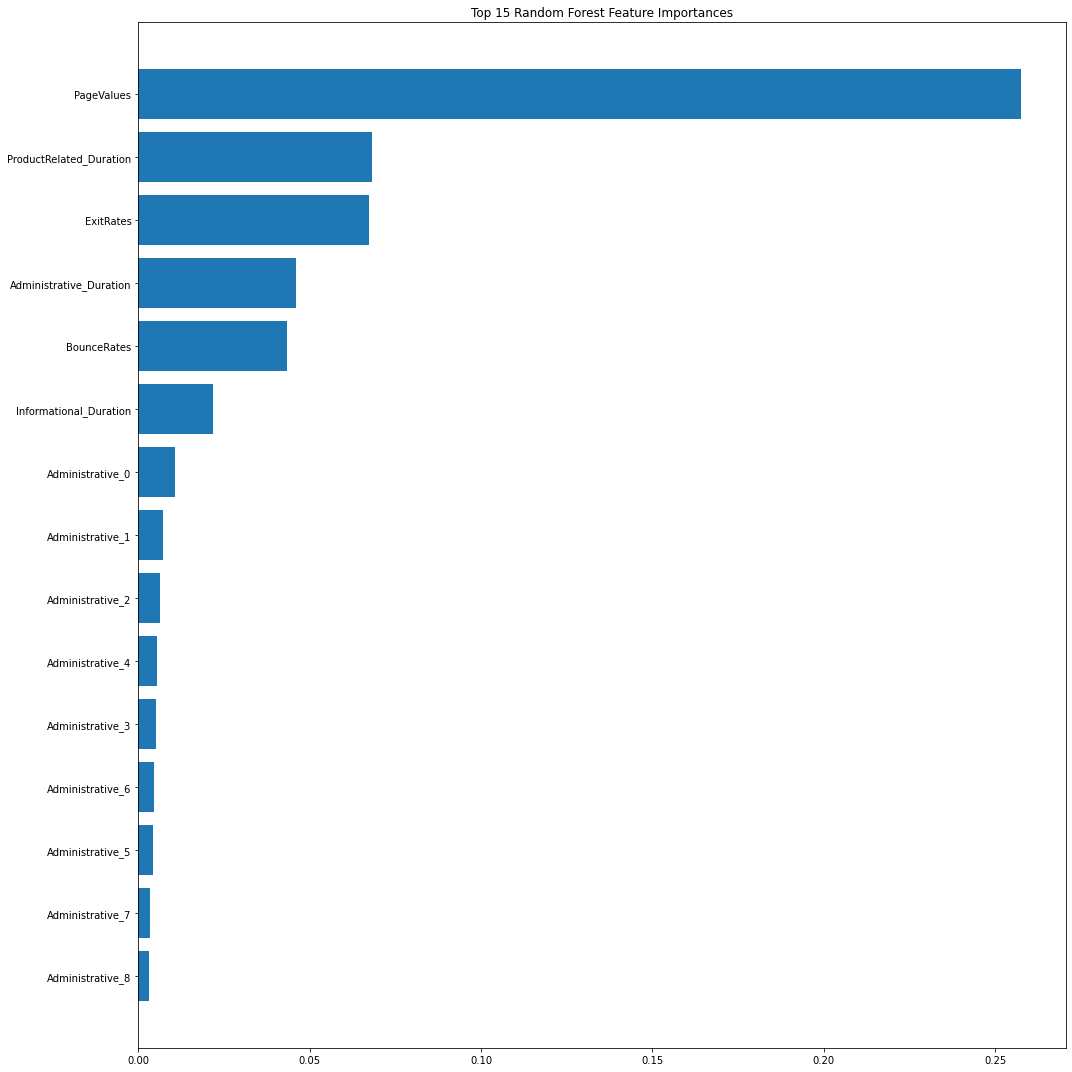

In [26]:
# Random forest feature importance
randomForestModel = RandomForestClassifier()
randomForestModel.fit(feaImpData, labels)
RFImportance = randomForestModel.feature_importances_[:15]
RFsortedIdx = RFImportance.argsort()[:15]

fig, ax = plt.subplots(figsize = (15,15))
ax.barh(y_ticks, RFImportance[RFsortedIdx])
ax.set_yticklabels(cols[RFsortedIdx])
ax.set_yticks(y_ticks)
ax.set_title("Top 15 Random Forest Feature Importances")
fig.tight_layout()
plt.show()

/home/hmnguyen1067/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_1439/1291017711.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(cols[XGBsortedIdx])


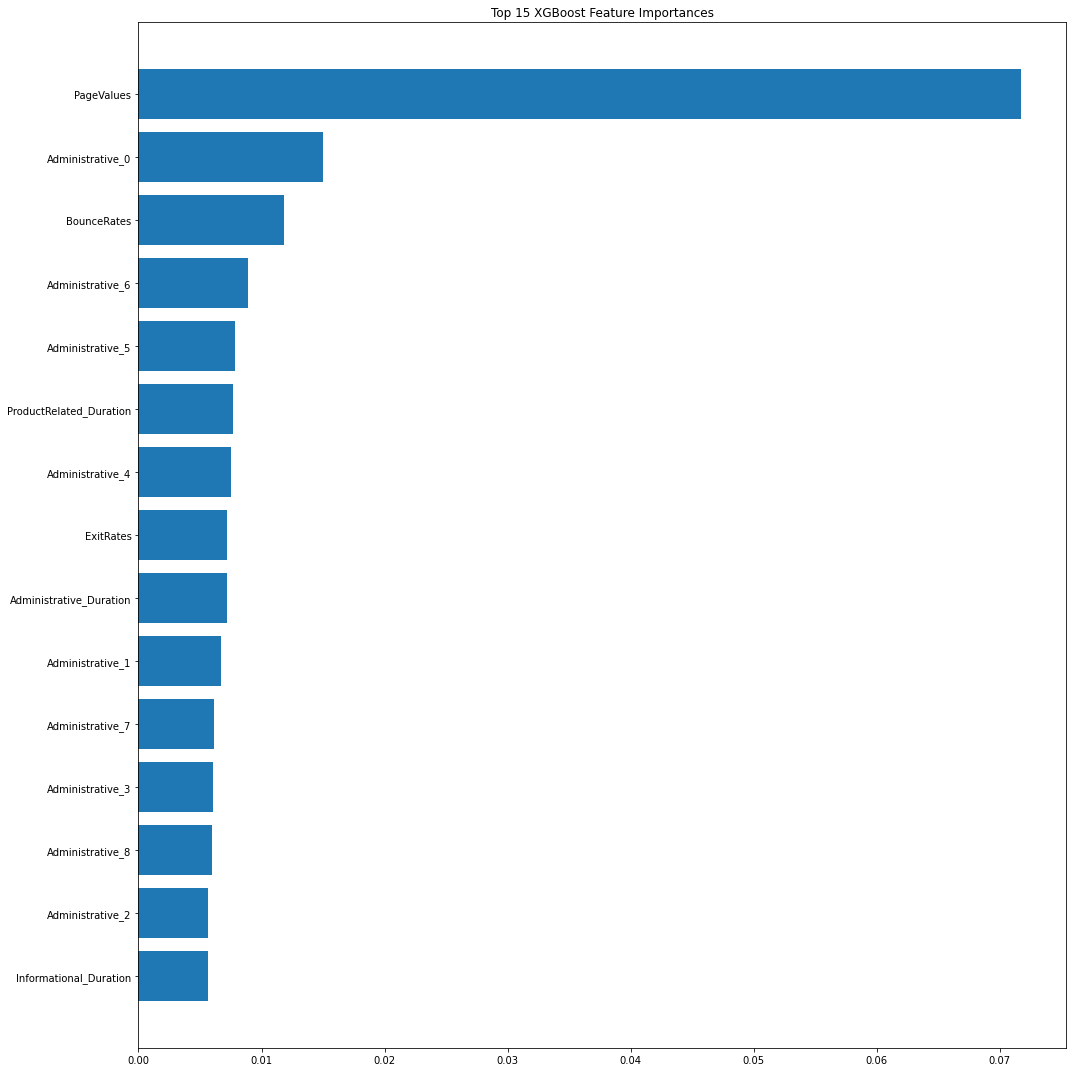

In [27]:
# XGBoost feature importance
XGBModel = xgb.XGBClassifier(use_label_encoder=False, verbosity = 0)
XGBModel.fit(feaImpData, labels)
XGBImportance = XGBModel.feature_importances_[:15]
XGBsortedIdx = XGBImportance.argsort()[:15]

fig, ax = plt.subplots(figsize = (15,15))
ax.barh(y_ticks, XGBImportance[XGBsortedIdx])
ax.set_yticklabels(cols[XGBsortedIdx])
ax.set_yticks(y_ticks)
ax.set_title("Top 15 XGBoost Feature Importances")
fig.tight_layout()
plt.show()

## Permutation importance

In [28]:
train_X, val_X, train_y, val_y = train_test_split(feaImpData, labels, random_state=1067)
permMod = RandomForestClassifier().fit(train_X, train_y)

In [29]:
permImp = PermutationImportance(permMod, random_state=1067).fit(val_X, val_y)
eli5.show_weights(permImp, feature_names = val_X.columns.tolist())

Weight,Feature
0.0711 ± 0.0098,PageValues
0.0132 ± 0.0033,ExitRates
0.0073 ± 0.0025,BounceRates
0.0045 ± 0.0032,ProductRelated_Duration
0.0045 ± 0.0027,Month_Nov
0.0014 ± 0.0013,Browser_2
0.0013 ± 0.0015,OperatingSystems_1
0.0012 ± 0.0011,VisitorType_New_Visitor
0.0010 ± 0.0007,Informational_1
0.0008 ± 0.0012,Informational_0


# Pipeline

In [30]:
# A transformer for preprocessing data in pipeline
dataPreprocessor = ColumnTransformer(
    [
        ('oh', OneHotEncoder(handle_unknown='ignore'), cat),
        ('scaler', StandardScaler(), num)
    ]
)

In [31]:
# The metrics that we will use
scorer = {
    'Accuracy': 'accuracy', 
    'AUC': 'roc_auc',
    'F1': 'f1'
    }

# Models hyperparameter space
lrParam = [{
    'lr__solver': ['saga'],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [10**i for i in range(-4,4)]
    }, {
    'lr__solver': ['lbfgs'],
    'lr__penalty': ['l2'],
    'lr__C': [10**i for i in range(-4,4)]
    }, {
    'lr__solver': ['lbfgs','saga'],
    'lr__penalty': ['none'],
}]

knnParam = {
    'knn__n_neighbors': np.arange(1,106,2),
    'knn__weights': ["uniform", "distance"]
}

rfParam = {
    'rf__n_estimators': [100, 150, 200, 400, 600],
    'rf__max_features': ["auto", "log2", None, 4, 6, 8, 10],
    'rf__criterion': ['entropy', 'gini'], 
    'rf__max_depth': [None, 5, 7, 9, 11]
}

lgbParam = {
    'lgb__boosting_type': ['gbdt', 'dart'],
    'lgb__n_estimators': [100, 400, 700, 1000],
    'lgb__learning_rate': [0.01, 0.05, 0.12],
    'lgb__num_leaves': [10, 20, 30, 50, 100],
}

xgbParam = {
    'xgb__eta': [0.01, 0.05, 0.1, 0.2, 0.5],
    'xgb__max_depth': [3, 6, 9, 12],
    'xgb__reg_alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 1],
    'xgb__subsample': [0.5, 0.7, 0.9, 1]
}

In [32]:
# Pipeline for each model
lrPipe = Pipeline([
    ('dp', dataPreprocessor),
    ('lr', LogisticRegression(random_state=1067))                
])

knnPipe = Pipeline([
    ('dp', dataPreprocessor),
    ('knn', KNeighborsClassifier())
])

rfPipe = Pipeline([
    ('dp', dataPreprocessor),
    ('rf', RandomForestClassifier(random_state=1067))
])

lgbPipe = Pipeline([
    ('dp', dataPreprocessor),
    ('lgb', lgb.LGBMClassifier(random_state=1067))
])

xgbPipe = Pipeline([
    ('dp', dataPreprocessor),
    ('xgb', xgb.XGBClassifier(random_state=1067,
                              use_label_encoder=False, 
                              verbosity = 0))
])

In [33]:
# A dictionary to loop through pipelines and parameters
pipeParam = {
    'lr': (lrPipe, lrParam),
    'knn': (knnPipe, knnParam),
    'rf': (rfPipe, rfParam),
    'lgb': (lgbPipe, lgbParam),
    'xgb': (xgbPipe, xgbParam)
}

# We want to split the data into train/dev/test set of ratio 0.75/0.15/0.15
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.15, 
                                                    random_state=1067,
                                                    stratify=labels)

X_train_dev, X_val, y_train_dev, y_val = train_test_split(X_train, y_train, 
                                                          test_size= 0.18, 
                                                          random_state=1067,
                                                          stratify=y_train) # 0.85 x 0.18 ≈ 0.15

# Model Evaluation and Hyperparameters tuning

In [34]:
def get_test_score(pipe: Pipeline, 
                param: dict, 
                score_function, 
                X_train, 
                X_test, 
                Y_train, 
                Y_test):
    """
    Given a pipeline and the parameters, the function will give the 
    metric score of the training and testing prediction.

    Parameters
    ----------
    pipe: Pipeline
    An algorithm model pipeline.

    param: dict
    The parameters the algorithm used for grid searching.

    score_function: sklearn.metrics
    A metric function to give a score.

    X_train, X_test, Y_train, Y_test: np.ndarray
    Training and testing data with labels already splitted.

    Returns
    -------
    Return the scores of the metrics given for the testing set.
    """                
    pipe.set_params(**param)
    pipe.fit(X_train, Y_train)
    y_pred_test = pipe.predict(X_test)
    trialTest = score_function(Y_test, y_pred_test)
    
    return trialTest

In [35]:
gsBestParams = {}
gsTestResults = {}

# For each model, we want to find the best parameter 
# setting each for every metrics.
for key in pipeParam:
    (pipe, param) = pipeParam.get(key)
    
    gs = RandomizedSearchCV(estimator=pipe, 
                      param_distributions=param, 
                      scoring=scorer,
                      cv=StratifiedKFold(7), 
                      refit = False,
                      random_state=1067)
    
    gs.fit(X_train_dev, y_train_dev)
    results = gs.cv_results_
    
    # Get best parameters for each metrics
    accuracy_best_index = np.argmin(results['rank_test_Accuracy'])
    accuracy_best_param = results['params'][accuracy_best_index]
    
    auc_best_index = np.argmin(results['rank_test_AUC'])
    auc_best_param = results['params'][auc_best_index]
    
    f1_best_index = np.argmin(results['rank_test_F1'])
    f1_best_param = results['params'][f1_best_index]
    
    aucTest = get_test_score(pipe, auc_best_param, 
                             roc_auc_score, X_train, X_test, 
                                          y_train, y_test)
    
    accTest = get_test_score(pipe, accuracy_best_param, 
                             accuracy_score, X_train, X_test, 
                                          y_train, y_test)
    
    f1Test = get_test_score(pipe, f1_best_param, f1_score, 
                            X_train, X_test, y_train, y_test)
    
    gsTestResults[key] = {
        'auc': aucTest,
        'acc': accTest,
        'f1': f1Test
    }
    
    gsBestParams[key] = {
        'auc': auc_best_param,
        'acc': accuracy_best_param,
        'f1': f1_best_param
    }

## Ensemble using voting

In [36]:
voteTestResult = {}

# Add a voting classifier 
for key, score_function in zip(['auc', 'acc', 'f1'], 
               [roc_auc_score, accuracy_score, f1_score]):
    voteClf = VotingClassifier(
        estimators = [
            ('lr', lrPipe.set_params(**gsBestParams['lr'][key])),
            ('knn', knnPipe.set_params(**gsBestParams['knn'][key])),
            ('rf', rfPipe.set_params(**gsBestParams['rf'][key])),
            ('lgb', lgbPipe.set_params(**gsBestParams['lgb'][key])),
            ('xgb', xgbPipe.set_params(**gsBestParams['xgb'][key]))
        ],
        voting='hard',
        weights = [1,1,3,2,2]
    )

    voteClf.fit(X_train, y_train)
    
    # File name: "model_clf_metric.joblib"
    joblib.dump(voteClf, 
                open(os.path.join(dest, f'vote_clf_{key}.joblib'), 
                     'wb'),
                protocol=4)

    y_pred = voteClf.predict(X_test)
        
    voteTestResult[key] = score_function(y_test, y_pred)
    
gsTestResults['vote'] = voteTestResult

## Ensemble using stacking

In [37]:
stackTestResult = {}

# Due to how ColumnTransformer doesn't work well
# with stacking so I redefine the pipelines
slr = Pipeline([
    ('lr', LogisticRegression(random_state=1067))                
])
sknn = Pipeline([
    ('knn', KNeighborsClassifier())
])

srf = Pipeline([
    ('rf', RandomForestClassifier(random_state=1067))
])

slgb = Pipeline([
    ('lgb', lgb.LGBMClassifier(random_state=1067))
])

sxgb = Pipeline([
    ('xgb', xgb.XGBClassifier(random_state=1067,
                              use_label_encoder=False, 
                              verbosity = 0))
])

X_stack_train = dataPreprocessor.fit_transform(X_train)
X_stack_test = dataPreprocessor.transform(X_test)

for key, score_function in zip(['auc', 'acc', 'f1'], 
               [roc_auc_score, accuracy_score, f1_score]):
    stackClf = StackingClassifier(
        estimators = [
            ('lr', slr.set_params(**gsBestParams['lr'][key])),
            ('knn', sknn.set_params(**gsBestParams['knn'][key])),
            ('rf', srf.set_params(**gsBestParams['rf'][key])),
            ('lgb', slgb.set_params(**gsBestParams['lgb'][key]))
        ],
        final_estimator = sxgb.set_params(**gsBestParams['xgb'][key]),
        cv = 5
    )
    
    stackClf.fit(X_stack_train, y_train)
    
    # File name: "model_clf_metric.joblib"
    joblib.dump(stackClf, 
                open(os.path.join(dest, f'stack_clf_{key}.joblib'), 
                     'wb'),
                protocol=4)
    
    y_pred = stackClf.predict(X_stack_test)
    
    stackTestResult[key] = score_function(y_test, y_pred)
    
gsTestResults['stack'] = stackTestResult

In [38]:
testResults = pd.DataFrame(gsTestResults).T
testResults

,auc,acc,f1
lr,0.689710,0.890811,0.534562
knn,0.656683,0.887027,0.527778
rf,0.808061,0.912973,0.700186
lgb,0.809320,0.911892,0.698706
xgb,0.794545,0.908649,0.680529
vote,0.803456,0.913514,0.700565
stack,0.814884,0.911351,0.696133


Based on the results above, we can see that besides voting and stacking method, Random Forest, XGBoost and Light GBM are all performing well. Since I have used RandomizedSearchCV above and for computational cost reason, I avoid GridSearchCV. I will try to find another way to tune the hyperparameters below.

# Deployment

In [39]:
# Save models on training dataset 
# (voting and stacking models already saved)
# File name: "model_clf_metric.joblib"
for key in gsBestParams:
    pipe, _ = pipeParam.get(key)
    
    for metric in gsBestParams.get(key):
        clf = pipe.set_params(**gsBestParams[key][metric])
        clf.fit(X_train, y_train)
    
        joblib.dump(clf, 
                    open(os.path.join(dest, f'{key}_clf_{metric}.joblib'), 'wb'),
                    protocol=4)